In [1]:
!pip install stable-baselines3 gymnasium JaxFin scienceplots

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 MB 5.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [2]:
!pip install sbx-rl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 2.3 MB/s eta 0:00:00


In [3]:
# @title Imports
# @markdown Do you want to save the model?
from abc import ABCMeta, abstractmethod
from itertools import product

import numpy as np
from numpy.random import choice

from gymnasium import Env, spaces
from gymnasium.spaces import Box, Discrete
from gymnasium.wrappers import NormalizeObservation
from google.colab import drive

from jax import vmap

from jaxfin.price_engine.fft import (
    delta_call_fourier,
    fourier_inv_call,
)
from jaxfin.models.heston.heston import UnivHestonModel

import matplotlib.pyplot as plt

from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecMonitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from sbx import TD3
import scienceplots

import pprint

import torch as th

SEED: int = 0
SAVE: bool = True # @param ["False", "True"] {type:"raw"}

plt.style.use(['science','no-latex'])
np.random.seed(SEED)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


## Heston environment


In [4]:
class HedgingEnvBase(Env):
    metadata = {"render.modes": ["human"]}
    action_space: spaces.Space
    observation_space: spaces.Space

    __metaclass__ = ABCMeta

    def __init__(
        self,
        s0: float,
        strike: float,
        expiry: float,
        r: float,
        mu: float,
        sigma: float,
        n_steps: int,
    ):
        self.s0 = s0
        self.strike = strike
        self.expiry = expiry
        self.r = r
        self.mu = mu
        self.sigma = sigma
        self.n_steps = n_steps
        self.dt = expiry / n_steps
        self._current_step = 0

        self.render_mode = "human"

        self._stock_path = np.array([])
        self._call_prices = np.array([])
        self._deltas = np.array([])

        self._current_pnl = 0.0
        self._hedging_portfolio_value = 0.0
        self._current_hedging_delta = 0.0
        self._previous_hedging_delta = 0.0
        self._back_account_value = 0.0
        self._ddelta = 0.0

        self._epsilon = 1
        self._lambda = 0.1
        self._tick_size = 0.05

    def reset(self, seed=None):
        super().reset(seed=seed)

        self._current_step = 0
        self._current_pnl = 0.0
        self._stock_path = self._generate_stock_path(seed=seed)
        self._call_prices = self._get_call_prices()
        self._deltas = self._get_deltas()
        self._hedging_portfolio_value = self._call_prices[0]
        self._current_hedging_delta = -self._deltas[0]
        self._back_account_value = -(
            self._hedging_portfolio_value + self.current_hedging_delta * self.s0
        )

        observations = self._get_observations()
        infos = self._get_infos()

        return observations, infos

    def step(self, action: float):
        self._current_step += 1

        done = self._current_step == (self.n_steps - 1)
        reward = self._calculate_reward()

        self._hedging_portfolio_value = self._calculate_hedging_portfolio_value(action)

        observations = self._get_observations()
        infos = self._get_infos()
        self._update_delta(action)

        return observations, reward, done, False, infos

    def render(self, mode="human"):
        pass

    def _update_delta(self, new_delta: float):
        self._ddelta = new_delta - self.current_hedging_delta
        self._previous_hedging_delta = self.current_hedging_delta
        self.current_hedging_delta = new_delta

    def _calculate_reward(self) -> float:
        pnl = self._calculate_pnl()
        self._current_pnl = pnl
        return pnl - self._lambda / 2 * pnl**2

    def _calculate_pnl(self) -> float:
        dv = (
            self._call_prices[self._current_step]
            - self._call_prices[self._current_step - 1]
        )
        ds = (
            self._stock_path[self._current_step]
            - self._stock_path[self._current_step - 1]
        )[0]
        ddelta = self._ddelta

        return (
            dv + self.current_hedging_delta * ds - self._get_transaction_costs(ddelta)
        )

    def _get_transaction_costs(self, ddelta: float):
        return self._epsilon * self._tick_size * (np.abs(ddelta) + 0.01 * ddelta**2)

    def _get_observations(self):
        log_price_strike = self._get_log_ratio()
        time_to_expiration = self.expiry
        bs_delta = self._deltas[self._current_step]
        call_price = self._call_prices[self._current_step]
        return np.asarray(
            [
                log_price_strike,
                self._get_current_stock_vol(self._current_step),
                time_to_expiration,
                bs_delta,
                call_price / self._call_prices[0],
                self.current_hedging_delta,
            ],
            dtype=np.float32,
        )

    def _get_infos(self):
        return {
            "price": self._call_prices[self._current_step],
            "time_to_expiration": self.expiry - self._current_step * self.dt,
            "bs_delta": self._deltas[self._current_step],
            "stock_price": self._get_current_stock_price(),
            "current_delta": self.current_hedging_delta,
            "log(S/K)": self._get_log_ratio(),
            "hedge_portfolio_value": self._hedging_portfolio_value,
            "bank_account": self._back_account_value,
            "current_pnl": self._current_pnl,
        }

    @property
    def current_hedging_delta(self):
        return self._current_hedging_delta

    @current_hedging_delta.setter
    def current_hedging_delta(self, new_hedge: float):
        self._current_hedging_delta = new_hedge

    def _get_log_ratio(self):
        if self._current_step == -1:
            return np.log(self.s0 / self.strike)
        return np.log(self._stock_path[self._current_step, 0] / self.strike)

    @abstractmethod
    def _get_current_stock_vol(self, step: int) -> float:
        raise NotImplementedError("Subclasses must implement this method")

    @abstractmethod
    def _generate_stock_path(self, seed=None) -> np.ndarray:
        raise NotImplementedError("Subclasses must implement this method")

    @abstractmethod
    def _get_call_prices(self) -> np.ndarray:
        raise NotImplementedError("Subclasses must implement this method")

    @abstractmethod
    def _get_deltas(self) -> np.ndarray:
        raise NotImplementedError("Subclasses must implement this method")

    def _calculate_hedging_portfolio_value(self, new_delta: float):
        new_hedging_port_value = (
            self._back_account_value
            + self._current_hedging_delta * self._get_current_stock_price()
        )
        self._back_account_value = (
            new_hedging_port_value - new_delta * self._get_current_stock_price()
        )

        return -new_hedging_port_value

    def _get_current_stock_price(self):
        return self._stock_path[self._current_step, 0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
v_delta_call_fourier = vmap(
    delta_call_fourier, in_axes=(0, None, None, None, None, None, None, None, None)
)
v_fouirer_inv_call = vmap(
    fourier_inv_call, in_axes=(0, None, None, None, None, None, None, None, None)
)


def flatten(fn):
    def wrapper(*args, **kwargs):
        return fn(*args, **kwargs).flatten()

    return wrapper


class HestonEnvBase(HedgingEnvBase):
    metadata = {"render.modes": ["human"]}
    action_space: spaces.Space
    observation_space: spaces.Space

    def __init__(
        self,
        s0: float,
        strike: float,
        expiry: float,
        r: float,
        mu: float,
        v0: float,
        kappa: float,
        theta: float,
        sigma: float,
        rho: float,
        n_steps: int,
    ):
        super().__init__(
            s0=s0,
            strike=strike,
            expiry=expiry,
            r=r,
            mu=mu,
            sigma=theta,
            n_steps=n_steps,
        )
        self.v0 = v0
        self.kappa = kappa
        self.theta = theta
        self.rho = rho
        self.vol_of_vol = sigma
        self._variance_process = np.asarray([])

    def _generate_stock_path(self, seed=None) -> np.ndarray:
        if seed:
            seed = 0

        heston_process = UnivHestonModel(
            s0=self.s0,
            v0=self.v0,
            mean=self.mu,
            kappa=self.kappa,
            theta=self.theta,
            sigma=self.vol_of_vol,
            rho=self.rho,
        )

        paths, variance_p = heston_process.sample_paths(self.expiry, self.n_steps, 1)
        paths = np.asarray(paths)
        variance_p = np.asarray(variance_p).squeeze()
        self._variance_process = variance_p

        return paths

    def _get_current_stock_vol(self, step: int) -> float:
        return np.sqrt(self._variance_process[step])

    @flatten
    def _get_call_prices(self) -> np.ndarray:
        return np.asarray(
            [
                fourier_inv_call(
                    s0=self._stock_path[i],
                    K=self.strike,
                    T=self.expiry - i * self.dt,
                    v0=self._variance_process[i],
                    mu=self.mu,
                    kappa=self.kappa,
                    theta=self.theta,
                    sigma=self.vol_of_vol,
                    rho=self.rho,
                )
                for i in range(self.n_steps)
            ]
        )

    @flatten
    def _get_deltas(self) -> np.ndarray:
        return np.asarray(
            [
                v_delta_call_fourier(
                    self._stock_path[i],
                    self.strike,
                    self.expiry - i * self.dt,
                    self._variance_process[i],
                    self.mu,
                    self.theta,
                    self.vol_of_vol,
                    self.kappa,
                    self.rho,
                )
                for i in range(self.n_steps)
            ]
        )


class HestonEnvCont(HestonEnvBase):

    def __init__(
        self,
        s0: float,
        strike: float,
        expiry: float,
        r: float,
        mu: float,
        v0: float,
        kappa: float,
        theta: float,
        sigma: float,
        rho: float,
        n_steps: int,
    ):
        super().__init__(
            s0=s0,
            strike=strike,
            expiry=expiry,
            r=r,
            mu=mu,
            v0=v0,
            kappa=kappa,
            theta=theta,
            sigma=sigma,
            rho=rho,
            n_steps=n_steps,
        )
        self.action_space = Box(low=-1, high=0.0, shape=(1,))
        self.observation_space = Box(
            low=np.array([-np.inf, 0.0, 0.0, 0.0, 0.0, -1.0], dtype=np.float32),
            high=np.array([np.inf, 2.0, np.inf, 1.0, np.inf, 1.0], dtype=np.float32),
            shape=(6,),
        )

    def step(self, action: np.ndarray):
        new_hedge = action[0]
        return super().step(new_hedge)


class HestonEnvDis(HestonEnvBase):

    def __init__(
        self,
        s0: float,
        strike: float,
        expiry: float,
        r: float,
        mu: float,
        v0: float,
        kappa: float,
        theta: float,
        sigma: float,
        rho: float,
        n_steps: int,
    ):
        super().__init__(
            s0=s0,
            strike=strike,
            expiry=expiry,
            r=r,
            mu=mu,
            v0=v0,
            kappa=kappa,
            theta=theta,
            sigma=sigma,
            rho=rho,
            n_steps=n_steps,
        )
        self.action_space = Discrete(100)
        self.observation_space = Box(
            low=np.array([-np.inf, 0.0, 0.0, 0.0, 0.0, -1.0], dtype=np.float32),
            high=np.array([np.inf, 2.0, np.inf, 1.0, np.inf, 1.0], dtype=np.float32),
            shape=(6,),
        )

    def step(self, action: float):
        return super().step(-(action / 100))

## T3D

In [6]:
s0 = 100
kappa = 1
theta = 0.04
sigma = 0.1 # vol of vol
rho = -0.7
v0 = 0.04

In [7]:
expires = [0.25, 0.5, 1.0, 2.0]
n_steps = [63, 126, 252, 504]
strikes = np.random.randint(low=int(s0 * 0.8), high=int(s0 * 1.2), size=20, dtype=int)

cartesian_product = list(product(strikes, expires, n_steps))

In [8]:
indexes = choice(np.asarray(range(len(cartesian_product))), 79, replace=False)
random_sample = np.asarray(cartesian_product)[indexes]

In [9]:
r = 0.0
mu = 0.0

init_s0 = 100
init_K = 100
init_T = 1.0
init_n_steps = 252

n_episodes = 100

In [10]:
def make_env(s0, strike, expiry, r, mu, v0, kappa, theta, sigma, rho, n_steps):
    def _create_env():
        return HestonEnvCont(s0, strike, expiry, r, mu, v0, kappa, theta, sigma, rho, n_steps)
    return _create_env

def make_vec_env(s0: float, strike: float, expiry:float, r, mu, v0, kappa, theta, sigma, rho, n_steps) -> Env:
    vec_env = DummyVecEnv([make_env(s0, strike, expiry, r, mu, v0, kappa, theta, sigma, rho, n_steps) for _ in range(5)])
    return VecMonitor(vec_env, filename='./training.log')

In [11]:
initial_env = make_vec_env(init_s0, init_K, init_T, r, mu, v0, kappa, theta, sigma, rho, init_n_steps)

In [12]:
learning_rate = 0.001
batch_size = 64
gamma = 0.9999
train_freq = 100
policy_kwargs = dict(net_arch=dict(pi=[64, 64], qf=[64, 64]))

model = TD3("MlpPolicy",
             initial_env,
             learning_rate=learning_rate,
             batch_size=batch_size,
             gamma=gamma,
             train_freq=train_freq,
             policy_kwargs=policy_kwargs,
             verbose=0)

## Training

In [13]:
model.learn(total_timesteps=252*n_episodes, log_interval=10, progress_bar=True)

Output()

In [14]:
training_rewards = [evaluate_policy(model, initial_env, n_eval_episodes=10)[0]]

In [15]:
# train loop
for K, T, steps in random_sample:
    n_steps = int(steps)
    print(f's0: {s0}, K: {K}, T: {T}, steps: {steps}')
    env = make_vec_env(s0, K, T,  r, mu, v0, kappa, theta, sigma, rho, n_steps)
    model.set_env(env)
    model.learn(total_timesteps=n_steps*n_episodes, log_interval=10, progress_bar=True)
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
    training_rewards.append(mean_reward)
    print(f'Episode reward: {mean_reward}')

s0: 100, K: 99.0, T: 2.0, steps: 63.0


Output()

Episode reward: -15.017385482788086
s0: 100, K: 104.0, T: 1.0, steps: 63.0


Output()

Episode reward: -3.1556479930877686
s0: 100, K: 103.0, T: 0.5, steps: 63.0


Output()

Episode reward: -0.6772671937942505
s0: 100, K: 104.0, T: 0.5, steps: 504.0


Output()

Episode reward: -4.118612766265869
s0: 100, K: 80.0, T: 0.5, steps: 252.0


Output()

Episode reward: -6.388894081115723
s0: 100, K: 97.0, T: 2.0, steps: 126.0


Output()

Episode reward: -12.51950454711914
s0: 100, K: 119.0, T: 0.5, steps: 504.0


Output()

Episode reward: -1.3058208227157593
s0: 100, K: 119.0, T: 0.5, steps: 504.0


Output()

Episode reward: -0.8897939920425415
s0: 100, K: 118.0, T: 0.5, steps: 63.0


Output()

Episode reward: -0.7987558245658875
s0: 100, K: 83.0, T: 0.5, steps: 126.0


Output()

Episode reward: -5.404279708862305
s0: 100, K: 89.0, T: 0.25, steps: 126.0


Output()

Episode reward: -1.6162300109863281
s0: 100, K: 104.0, T: 0.25, steps: 504.0


Output()

Episode reward: -2.9241795539855957
s0: 100, K: 104.0, T: 0.5, steps: 504.0


Output()

Episode reward: 0.008961940184235573
s0: 100, K: 101.0, T: 0.5, steps: 252.0


Output()

Episode reward: -1.4600549936294556
s0: 100, K: 80.0, T: 2.0, steps: 504.0


Output()

Episode reward: -26.232324600219727
s0: 100, K: 104.0, T: 2.0, steps: 126.0


Output()

Episode reward: -13.622230529785156
s0: 100, K: 92.0, T: 0.5, steps: 63.0


Output()

Episode reward: -4.1505889892578125
s0: 100, K: 104.0, T: 0.5, steps: 252.0


Output()

Episode reward: -3.6517817974090576
s0: 100, K: 81.0, T: 0.25, steps: 504.0


Output()

Episode reward: 0.2915804982185364
s0: 100, K: 83.0, T: 1.0, steps: 252.0


Output()

Episode reward: -15.402467727661133
s0: 100, K: 104.0, T: 0.5, steps: 63.0


Output()

Episode reward: -4.258749485015869
s0: 100, K: 116.0, T: 0.25, steps: 126.0


Output()

Episode reward: -4.696699142456055
s0: 100, K: 97.0, T: 1.0, steps: 126.0


Output()

Episode reward: -6.710703372955322
s0: 100, K: 119.0, T: 2.0, steps: 252.0


Output()

Episode reward: -4.767251491546631
s0: 100, K: 119.0, T: 0.5, steps: 252.0


Output()

Episode reward: -2.8699381351470947
s0: 100, K: 119.0, T: 1.0, steps: 504.0


Output()

Episode reward: -1.0400371551513672
s0: 100, K: 104.0, T: 0.5, steps: 126.0


Output()

Episode reward: -2.0138659477233887
s0: 100, K: 97.0, T: 0.5, steps: 504.0


Output()

Episode reward: -3.9028193950653076
s0: 100, K: 81.0, T: 2.0, steps: 504.0


Output()

Episode reward: -29.73598861694336
s0: 100, K: 118.0, T: 2.0, steps: 252.0


Output()

Episode reward: -3.918363094329834
s0: 100, K: 83.0, T: 0.5, steps: 63.0


Output()

Episode reward: -5.24282169342041
s0: 100, K: 89.0, T: 1.0, steps: 252.0


Output()

Episode reward: -14.564285278320312
s0: 100, K: 119.0, T: 0.5, steps: 63.0


Output()

Episode reward: -2.3866519927978516
s0: 100, K: 86.0, T: 2.0, steps: 504.0


Output()

Episode reward: -24.403167724609375
s0: 100, K: 118.0, T: 1.0, steps: 504.0


Output()

Episode reward: -2.113243579864502
s0: 100, K: 80.0, T: 0.5, steps: 504.0


Output()

Episode reward: 0.46170204877853394
s0: 100, K: 97.0, T: 0.25, steps: 126.0


Output()

Episode reward: -0.4560249447822571
s0: 100, K: 104.0, T: 2.0, steps: 252.0


Output()

Episode reward: -12.973437309265137
s0: 100, K: 104.0, T: 2.0, steps: 63.0


Output()

Episode reward: -15.684707641601562
s0: 100, K: 116.0, T: 2.0, steps: 63.0


Output()

Episode reward: -11.591375350952148
s0: 100, K: 119.0, T: 2.0, steps: 504.0


Output()

Episode reward: -3.7886390686035156
s0: 100, K: 119.0, T: 1.0, steps: 63.0


Output()

Episode reward: -2.2351319789886475
s0: 100, K: 86.0, T: 0.5, steps: 252.0


Output()

Episode reward: -2.86838436126709
s0: 100, K: 118.0, T: 0.5, steps: 126.0


Output()

Episode reward: 0.07407967746257782
s0: 100, K: 86.0, T: 0.25, steps: 126.0


Output()

Episode reward: -0.724453330039978
s0: 100, K: 89.0, T: 2.0, steps: 63.0


Output()

Episode reward: -31.47505760192871
s0: 100, K: 99.0, T: 0.5, steps: 504.0


Output()

Episode reward: -1.0496940612792969
s0: 100, K: 92.0, T: 2.0, steps: 252.0


Output()

Episode reward: -12.657744407653809
s0: 100, K: 104.0, T: 2.0, steps: 504.0


Output()

Episode reward: -9.260178565979004
s0: 100, K: 104.0, T: 0.5, steps: 126.0


Output()

Episode reward: -3.669583797454834
s0: 100, K: 101.0, T: 0.5, steps: 63.0


Output()

Episode reward: 0.49025869369506836
s0: 100, K: 89.0, T: 0.25, steps: 63.0


Output()

Episode reward: 3.39347767829895
s0: 100, K: 89.0, T: 0.5, steps: 63.0


Output()

Episode reward: -1.5987606048583984
s0: 100, K: 116.0, T: 2.0, steps: 252.0


Output()

Episode reward: -5.385282516479492
s0: 100, K: 97.0, T: 1.0, steps: 63.0


Output()

Episode reward: -8.159735679626465
s0: 100, K: 119.0, T: 2.0, steps: 63.0


Output()

Episode reward: -8.253889083862305
s0: 100, K: 119.0, T: 0.5, steps: 252.0


Output()

Episode reward: -1.220670461654663
s0: 100, K: 103.0, T: 2.0, steps: 63.0


Output()

Episode reward: -12.650704383850098
s0: 100, K: 116.0, T: 1.0, steps: 63.0


Output()

Episode reward: 2.3504650592803955
s0: 100, K: 117.0, T: 1.0, steps: 63.0


Output()

Episode reward: -0.10122716426849365
s0: 100, K: 116.0, T: 0.5, steps: 63.0


Output()

Episode reward: -0.6061750650405884
s0: 100, K: 83.0, T: 0.5, steps: 126.0


Output()

Episode reward: -0.7857309579849243
s0: 100, K: 116.0, T: 1.0, steps: 252.0


Output()

Episode reward: -3.2588112354278564
s0: 100, K: 104.0, T: 0.25, steps: 252.0


Output()

Episode reward: -0.8673016428947449
s0: 100, K: 103.0, T: 1.0, steps: 126.0


Output()

Episode reward: -5.10781717300415
s0: 100, K: 119.0, T: 0.25, steps: 126.0


Output()

Episode reward: -0.3431139588356018
s0: 100, K: 103.0, T: 2.0, steps: 126.0


Output()

Episode reward: -14.774299621582031
s0: 100, K: 86.0, T: 2.0, steps: 63.0


Output()

Episode reward: -23.235149383544922
s0: 100, K: 89.0, T: 2.0, steps: 252.0


Output()

Episode reward: -21.070898056030273
s0: 100, K: 118.0, T: 1.0, steps: 63.0


Output()

Episode reward: -1.0720633268356323
s0: 100, K: 83.0, T: 0.5, steps: 252.0


Output()

Episode reward: -2.727820634841919
s0: 100, K: 104.0, T: 0.25, steps: 504.0


Output()

Episode reward: -0.7138553857803345
s0: 100, K: 103.0, T: 1.0, steps: 63.0


Output()

Episode reward: -9.157575607299805
s0: 100, K: 89.0, T: 0.25, steps: 252.0


Output()

Episode reward: 1.2602789402008057
s0: 100, K: 118.0, T: 1.0, steps: 126.0


Output()

Episode reward: 2.2122626304626465
s0: 100, K: 80.0, T: 2.0, steps: 63.0


Output()

Episode reward: -21.853342056274414
s0: 100, K: 104.0, T: 1.0, steps: 504.0


Output()

Episode reward: -4.660251617431641
s0: 100, K: 103.0, T: 0.5, steps: 504.0


Output()

Episode reward: -1.7812139987945557
s0: 100, K: 83.0, T: 0.25, steps: 126.0


Output()

Episode reward: -1.3754194974899292


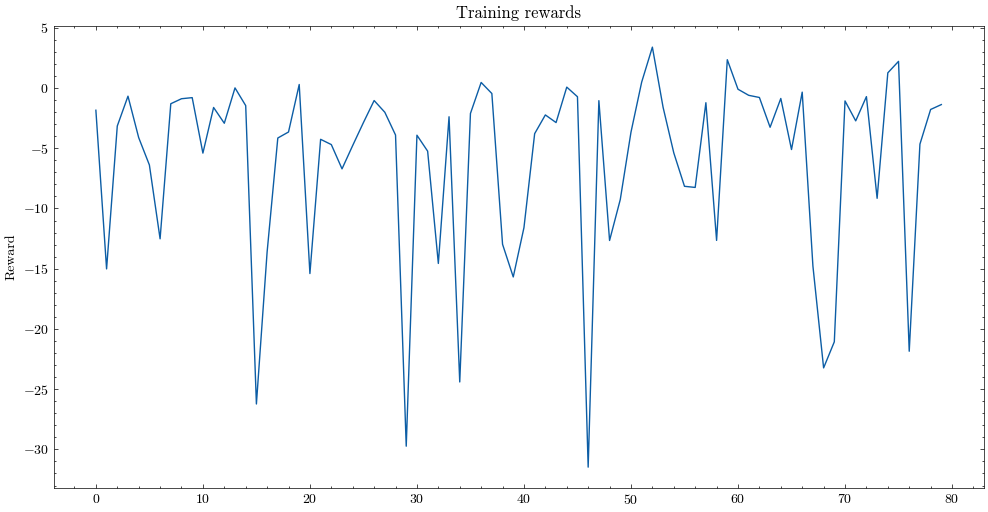

In [16]:
fig = plt.figure(figsize=(12, 6))

plt.plot(training_rewards)
plt.title('Training rewards')
plt.ylabel('Reward')
plt.show()

### Save the model

In [17]:
if SAVE:
    drive.mount('/content/drive')
    SAVE_MODEL_DIR = "/content/drive/MyDrive/Uni DK/Master's Thesis/Nets/"
    model.save(SAVE_MODEL_DIR + "td3-heston-high")

Mounted at /content/drive


## Evaluation

In [18]:
test_env = HestonEnvCont(s0, init_K, init_T, r, mu, v0, kappa, theta, sigma, rho, init_n_steps)
obs, info = test_env.reset(seed=SEED)

pp = pprint.PrettyPrinter(indent=4)
log_infos = False

rewards = []
hedges = []
bs_deltas = []
hedge_port = []
call_price = []

for i in range(252):
    action, _states = model.predict(obs)

    obs, reward, done, _, info = test_env.step(action)

    rewards.append(reward)
    hedges.append(action)
    bs_deltas.append(info['bs_delta'])
    hedge_port.append(info['hedge_portfolio_value'])
    call_price.append(info['price'])

    if log_infos:
        print(f'Step: {i}')
        print('Action:', action)
        print('Observations:')
        pp.pprint(obs)
        print('Infos')
        pp.pprint(info)
        print('Reward:', reward)

    if done:
        break

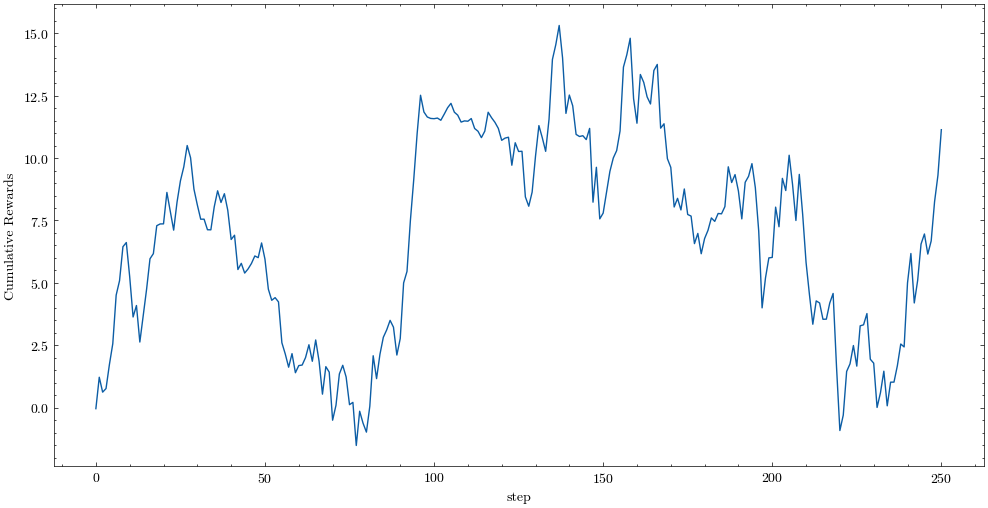

In [19]:
fig = plt.figure(figsize=(12, 6))

plt.plot(np.cumsum(rewards))
plt.xlabel('step')
plt.ylabel('Cumulative Rewards')
plt.show()

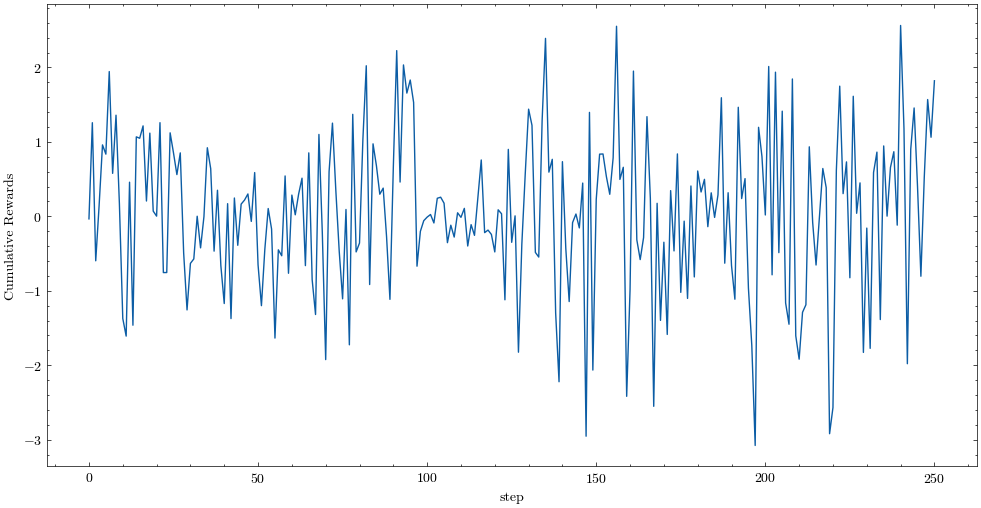

In [20]:
fig = plt.figure(figsize=(12, 6))

plt.plot(rewards)
plt.xlabel('step')
plt.ylabel('Cumulative Rewards')
plt.show()

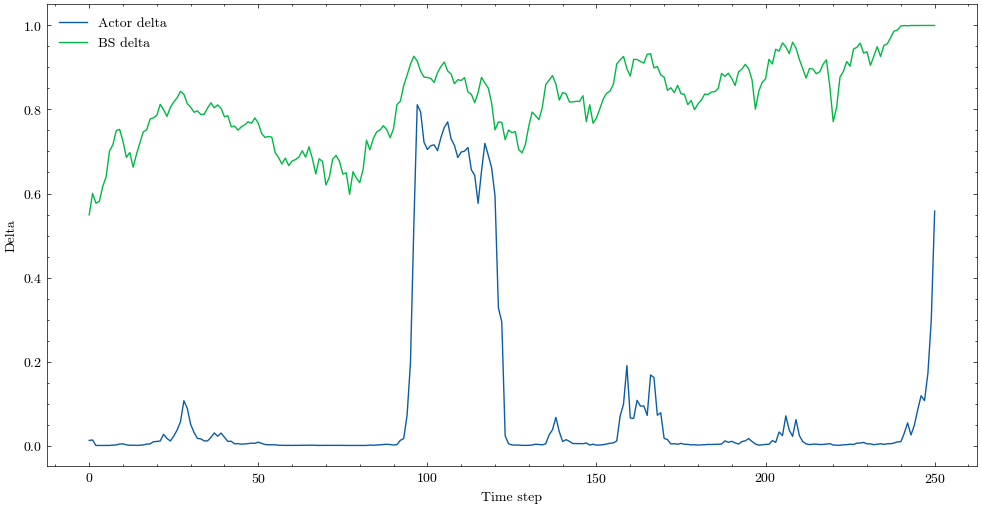

In [21]:
fig = plt.figure(figsize=(12, 6))

plt.plot(-np.array(hedges), label='Actor delta')
plt.plot(bs_deltas, label='BS delta')
plt.xlabel('Time step')
plt.ylabel('Delta')
plt.legend()
plt.show()

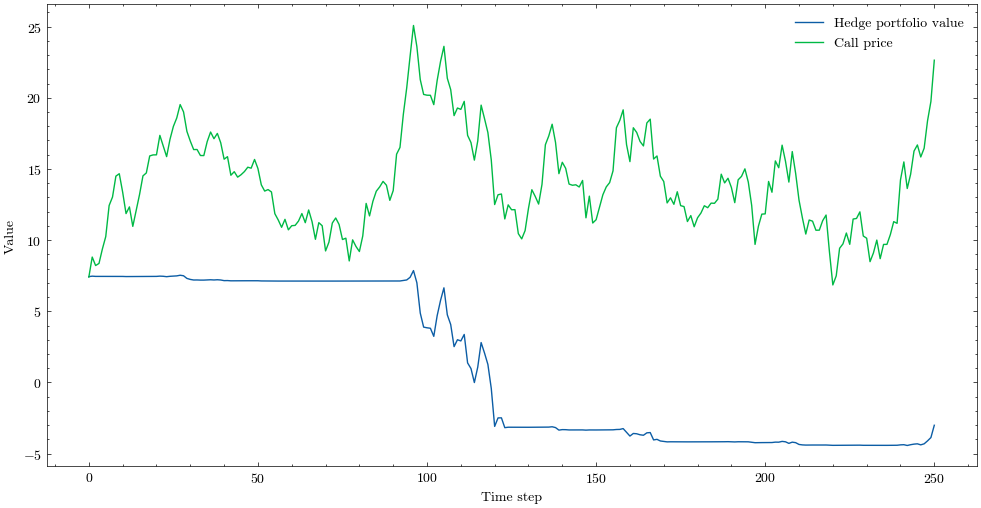

In [22]:
fig = plt.figure(figsize=(12, 6))

plt.plot(hedge_port, label='Hedge portfolio value')
plt.plot(call_price, label='Call price')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.legend()
plt.show()